# 고급 알고리즘 전략

- 거래 상품 변동성을 조정하는 트레이딩 전략

- 경제 이벤트에 대한 트레이딩 전략

- 기본적인 통계 차익 트레이딩 전략    

In [1]:
!pip install finance-datareader
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\jh102\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\jh102\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import seaborn

start_date = '2019-01-01'
end_date = '2023-01-01'

data = fdr.DataReader('GOOG', start_date, end_date)

### 변동성 조정 평균 회귀 트레이딩 전략

APO 트레이딩 시그널 평균 회귀 전략

In [ ]:
# basic_mean_reversion

# EMA 계산을 위한 변수 / 상수
NUM_PERIODS_FAST = 10 
K_FAST = 2 / (NUM_PERIODS_FAST + 1) 
ema_fast = 0
ema_fast_values = [] 

NUM_PERIODS_SLOW = 40 
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) 
ema_slow = 0
ema_slow_values = [] 

apo_values = [] 

# 포지션과 손익계산을 위한 변수
orders = [] 
positions = [] 
pnls = [] 

last_buy_price = 0 
last_sell_price = 0 
position = 0 
buy_sum_price_qty = 0 
buy_sum_qty = 0 
sell_sum_price_qty = 0 
sell_sum_qty = 0 
open_pnl = 0 
closed_pnl = 0 

# 트레이딩 전략 구현을 위한 상수
APO_VALUE_FOR_BUY_ENTRY = -10 
APO_VALUE_FOR_SELL_ENTRY = 10 
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
NUM_SHARES_PER_TRADE = 10 
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE

close=data['Close']
for close_price in close:
  # APO트레이딩 시그날 계산을 위한 Slow/Fast EMA
  if (ema_fast == 0): 
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # Trading Signal

  # 매도
  if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) 
    or
    (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))):
    orders.append(-1) 
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE 
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) 
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  # 매수
 
  elif ((apo > APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) 
    or
    (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): 
    orders.append(+1) 
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE 
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) 
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    
    orders.append(0)

  positions.append(position)

  # 체결 / 미체결 포지션 업데이트
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0:
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: 
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)

# 트레이딩 전략 결과 기록을 위한 데이터 프레임
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

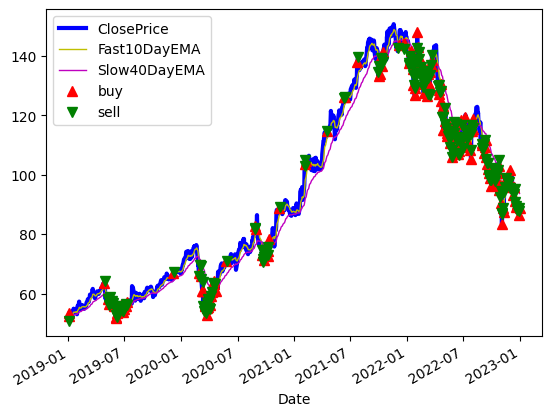

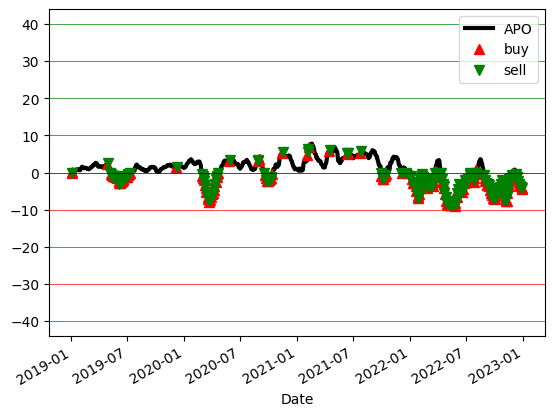

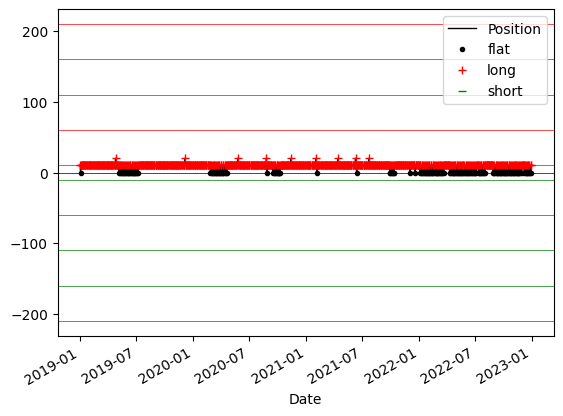

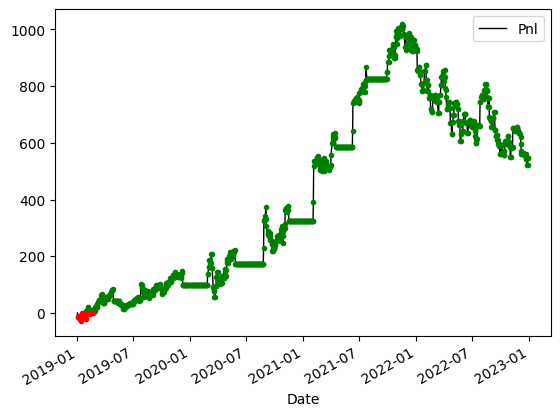

In [4]:
import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

# data.to_csv("basic_trend_following.csv", sep=",")

### 변동성 조정 평균 회귀 트레이딩 전략

변동성 변동을 동적으로 조정하는 평균 회귀 전략

In [ ]:
# 변동성 척도가 20일 $8에서 20일 40$ 사이의 범위에 있다면, 20일 $15가 평균이다.
# 따라서 stdev_f_actor = stdev/15 으로 설정해서 0과 1사이의 변동성 척도를 사용한다.
# 1주위의 값이 정상 변동성으로 0에 가까울수록 매우 낮은 변동성, 1을 초과하면 높은 변동성을 의미한다.

# "STDEV를 전략에 통합하는 방법"
# 빠르고 느린 EMA에 대해 정적 K_FAST, K_SLOW 평활화 계수 대신, 이들을 변동성의 함수로 만들고,
# K_FAST_stdev_factor 및 K_SLOW_stdev_factor을 사용해 변동성이 정상보다 높은 기간 동안 최신 관찰값에 대해 더 반응하도록 한다.
# 마찬가지로 정적 APO_VALUE_FOR_BUY_ENTRY 임계값 대신 동적 임계값 APO_VALUE_FOR_BUY_ENTRY*stdev_factor을 갖도록 변동성을 통합한다.
# 즉, 변동성 비율로 진입 임계값을 증가시킴으로서 변동성이 높은 기간동안 포지션에 진입하는 것을 덜 공격적으로 만든다.
# 마찬가지로, 변동성을 하나의 마지막 임계값을 결합시리는데, 동적 예상 이익 임계값을 설정해 포지션에서 이익을 고정시킨다.
# 정적 IN_PROFIT_TO_CLOSE 임계값을 사용하는 대신 MIN_PROFIT_TO_CLOSE / stdev_factor을 사용한다. 변동성이 증가한 기간에 포지션 청산에 적극적이다.

In [5]:
start_date = '2019-01-01'
end_date = '2023-01-01'

data = fdr.DataReader('GOOG', start_date, end_date)

In [ ]:
# volatility_adjusted_mean_reversion

# EMA 계산을 위한 변수 / 상수
NUM_PERIODS_FAST = 10 # 빠른 EMA 정적 기간 파라미터
K_FAST = 2 / (NUM_PERIODS_FAST + 1) # 빠른 EMA를 위한 정적 평활화 벡터  
ema_fast = 0
ema_fast_values = [] # 시각화 목적을 위해서 빠른 EMA 값을 보존.

NUM_PERIODS_SLOW = 40 # 느린 EMA 정적 파라미터
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) # 느린 EMA를 위한 정적 평활화 벡터
ema_slow = 0
ema_slow_values = [] # 시각화 목적을 위해서 느린 EMA값을 보존한다.

apo_values = [] # 계산된 APO값 시그널을 추적한다.

# 트레이딩 전략 트레이드, 포지션과 pnl 관리를 위한 변수
orders = [] # 매수/매도 주문용 변수, 매수 +1, 매도 -1, 주문없을땐 0
positions = [] # 포지션 추적 변수, Long +, Short -, Position X 0
pnls = [] # 총손익을 추적하는 변수, close_pnl과 open_pnl의 합.

last_buy_price = 0 # 마지막 매수 트레이드의 가격, 동일한 가격 또는 주변 가격으로 과다 트레이딩 하는 것을 방지.
last_sell_price = 0 
position = 0 # 현재 포지션
buy_sum_price_qty = 0 # Summation of 매수 거래 가격*매수 거래량
buy_sum_qty = 0 # Summation of 매수 거래량의 곱
sell_sum_price_qty = 0 
sell_sum_qty = 0 
open_pnl = 0 # 미체결/미실현 Pnl
closed_pnl = 0 # 체결/실현된 Pnl

# 전략 행태/임계값을 정의하는 상수
APO_VALUE_FOR_BUY_ENTRY = -10 # 롱 포지션에 들어가는 APO 트레이딩 시그널 값.
APO_VALUE_FOR_SELL_ENTRY = 10 # 숏 포지션에 들어가는 APO 트레이딩 시그널 값.
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 # 트레이딩 재개하기 이전 마지막 거래로부터의 최소 가격 변화. 과다 트레이딩 방지.
NUM_SHARES_PER_TRADE = 10 # 포지션을 청산하고 이익을 고정시키는 최소 미체결/미실현 이익
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE # 모든 트레이드에 있어서 최소 매수/매도 주식수

import statistics as stats
import math as math

# standard deviation as a volatility 를 계산하기 위한 변수/상수
SMA_NUM_PERIODS = 20 # look back period
price_history = [] 

# 이동평균과 표준편차 계산.
close=data['Close']
for close_price in close:
  price_history.append(close_price)
  if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
    del (price_history[0])

  sma = stats.mean(price_history)
  variance = 0 # variance is square of standard deviation
  for hist_price in price_history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(price_history))
  stdev_factor = stdev/5 # 2장에서 해당 기간 구글 주식의 변동성의 평균이 4~5로 나타나 해당 값을 적용.
  if stdev_factor == 0:
    stdev_factor = 1

    # 빠른/느린 EMA를 업데이트하고 APO 시그널 계산.
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

   # Trading Signal

 # 다음 조건이 충족되면 close_price로 매도 거래를 수행.
 # 1. APO 트레이딩 시그널 값이 Sell-Entry 임계값보다 높으며, 마지막 거래 가격과 현재 가격의 차이가 충분히 다름.
 # 2. 롱이고 APO 트레이딩 시그널 값이 0 이상이거나 현재 포지션이 이익을 고정시킬 만큼 충분한 수익성

  if ((apo > APO_VALUE_FOR_SELL_ENTRY*stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
    or
    (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): 
    orders.append(-1) # 매도 거래 표시
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE 
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE)
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  elif ((apo < APO_VALUE_FOR_BUY_ENTRY*stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
    or
    (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): 
    orders.append(+1) 
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE 
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) 
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    
    orders.append(0)

  positions.append(position)

   # 미체결/미실현과 체결/실현 포지션 업데이트
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: # 롱 포지션과 이에 대한 매도 거래 수행. 롱 포지션에 대해 얼마만큼 매도하는가를 기반으로 청산.
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # 잔여 포지션을 시장 가격으로 평가.
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: # 숏 포지션과 이에 대한 매수 거래 수행.
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # 잔여 포지션을 시장 가격으로 평가
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    # 포지션이 없으면 청산된 손익 업데이트. 포지션과 Pnls을 추적하기 위한 변수들을 재설정.
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)

  # 트레이딩 전략 결과를 위한 데이터 프레임   
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

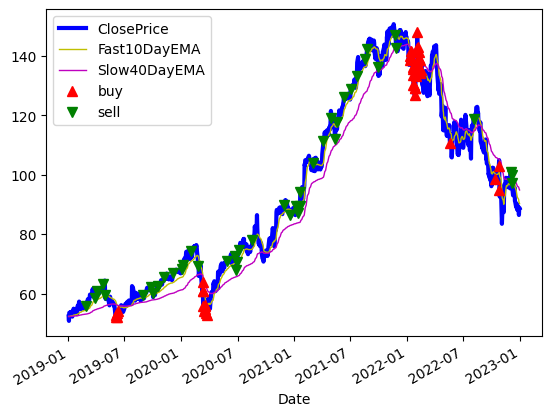

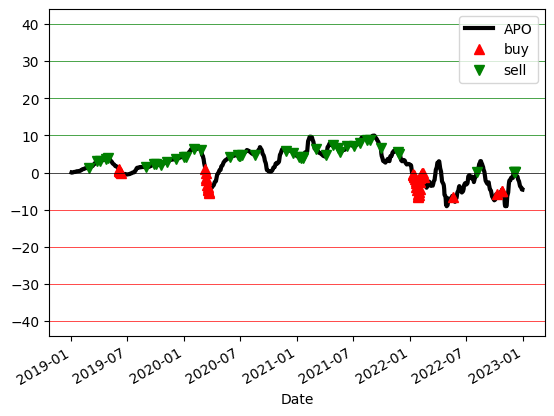

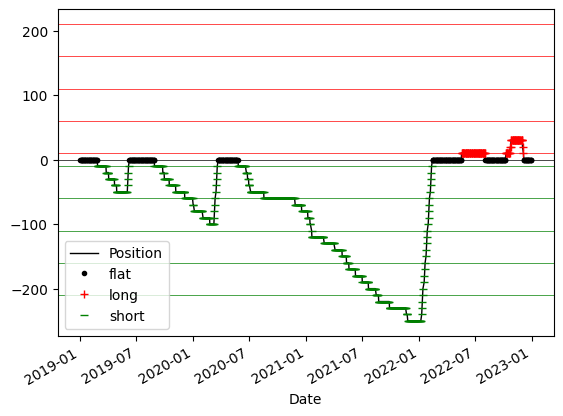

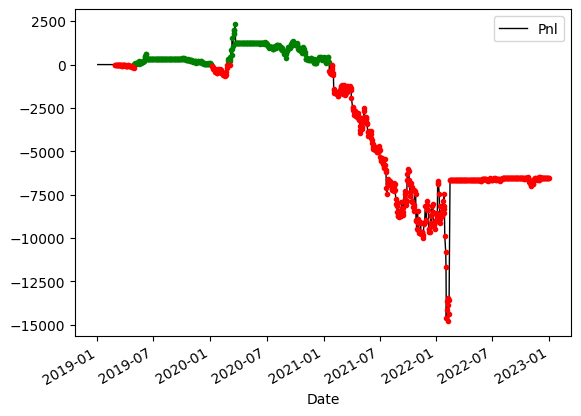

In [7]:
import matplotlib.pyplot as plt
# 주식가격 변화에 따른 매수매도 확인

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

# APO 트레이딩 시그널에 따른 매수매도 확인  
data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

# 포지션 확인 
data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

#Pnl의 움직인 확인  
data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

# data.to_csv("volatility_adjusted_mean_reversion.csv", sep=",")

### APO 트레이딩 시그널을 활용한 추세추정 전략

평균 회귀 전략과 유사하게 APO 트레이딩 시그널을 사용하는 추세 추종 전략.
APO가 특정 값을 초과할 때 롱 포지션에 진입.

In [8]:
start_date = '2019-01-01'
end_date = '2023-01-01'

data = fdr.DataReader('GOOG', start_date, end_date)

In [ ]:
# EMA 계산을 위한 변수 / 상수
NUM_PERIODS_FAST = 10 
K_FAST = 2 / (NUM_PERIODS_FAST + 1) 
ema_fast = 0
ema_fast_values = [] 

NUM_PERIODS_SLOW = 40 
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) 
ema_slow = 0
ema_slow_values = [] #

apo_values = [] 

# 트레이딩 전략 트레이드, 포지션과 pnl 관리를 위한 변수
orders = [] 
positions = [] 
pnls = [] 

last_buy_price = 0 
last_sell_price = 0 
position = 0 
buy_sum_price_qty = 0  
buy_sum_qty = 0 
sell_sum_price_qty = 0 
sell_sum_qty = 0 
open_pnl = 0 
closed_pnl = 0 # 

# 전략 행태/임계값을 정의하는 상수
APO_VALUE_FOR_BUY_ENTRY = -10 
APO_VALUE_FOR_SELL_ENTRY = 10 
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10 
NUM_SHARES_PER_TRADE = 10 
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE 

close=data['Close']
for close_price in close:
  # update Fast EMA, slow EMA
  if (ema_fast == 0): 
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # trading signal.

  
  
  
  if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)
    or
    (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): 
    orders.append(-1) 
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE 
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) 
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  
  elif ((apo > APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) 
    or
    (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): 
    orders.append(+1) 
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE 
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) 
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    
    orders.append(0)

  positions.append(position)

  # 미체결/미실현과 체결/실현 포지션 업데이트
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: 
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: 
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
   
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)

# 트레이딩 전략 결과 기록
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

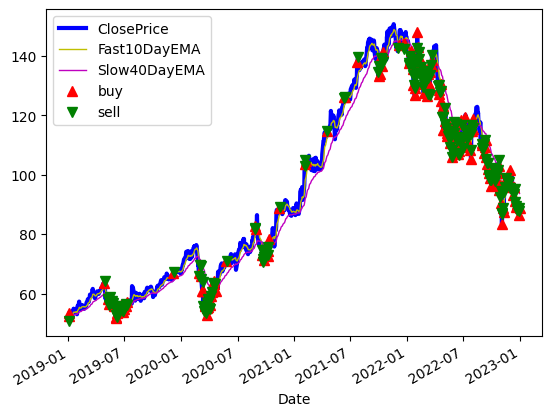

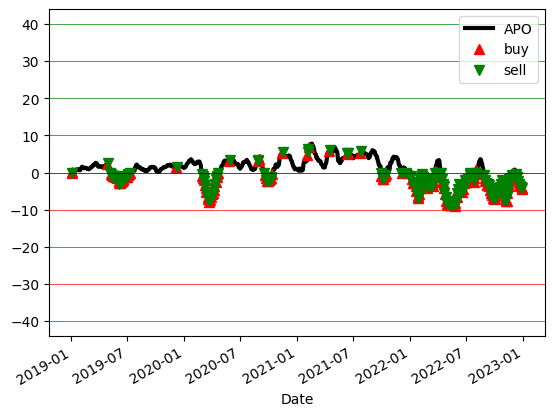

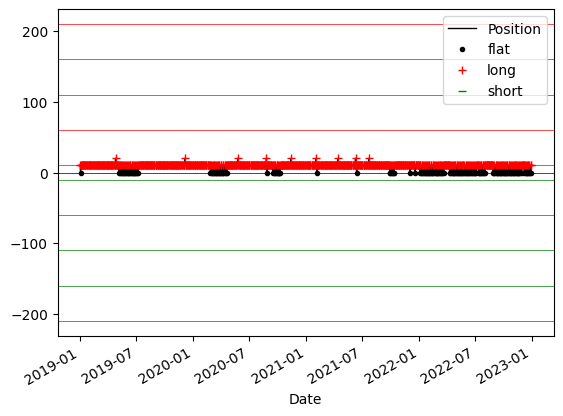

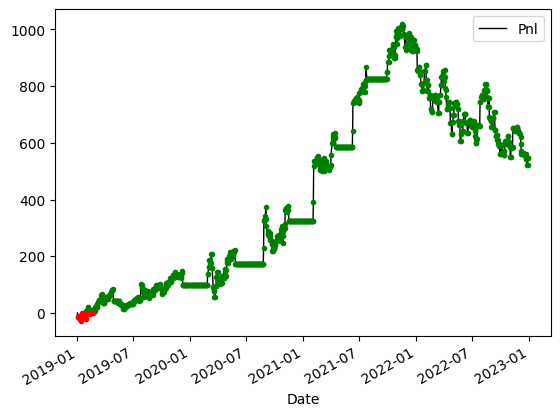

In [10]:
import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

# data.to_csv("basic_trend_following.csv", sep=",")

### 변동성 변동 동적 조정 추세 추종 전략

In [11]:
start_date = '2019-01-01'
end_date = '2023-01-01'

data = fdr.DataReader('GOOG', start_date, end_date)

In [ ]:
# volatility_adjusted_trend_following
# 앞선 예시와 같이 변수와 상수들을 정의한다
# 데이터는 구글 데이터를 동일하게 사용한다.

NUM_PERIODS_FAST = 10 
K_FAST = 2 / (NUM_PERIODS_FAST + 1) 
ema_fast = 0
ema_fast_values = [] 

NUM_PERIODS_SLOW = 40 
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1) 
ema_slow = 0
ema_slow_values = [] 

apo_values = [] 


orders = [] 
positions = [] 
pnls = [] 

last_buy_price = 0 
last_sell_price = 0 
position = 0 
buy_sum_price_qty = 0
buy_sum_qty = 0 
sell_sum_price_qty = 0 
sell_sum_qty = 0 
open_pnl = 0 
closed_pnl = 0 

# 거래 전략 
APO_VALUE_FOR_BUY_ENTRY = 10 
APO_VALUE_FOR_SELL_ENTRY = -10 
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
NUM_SHARES_PER_TRADE = 10 
MIN_PROFIT_TO_CLOSE = 10*NUM_SHARES_PER_TRADE

import statistics as stats
import math as math

# 변동성 척도로 표준편차를 계산하고자 하는 상수/변수
SMA_NUM_PERIODS = 20 # 룩백 기간
price_history = [] # 가격 히스토리

# 전략의 포지션 및 Pnl관리 섹션은 동일하게 유지.

close=data['Close']
for close_price in close:
  price_history.append(close_price)
  if len(price_history) > SMA_NUM_PERIODS: # we track at most 'time_period' number of prices
    del (price_history[0])

  sma = stats.mean(price_history)
  variance = 0 # variance = square of standard deviation
  for hist_price in price_history:
    variance = variance + ((hist_price - sma) ** 2)

  stdev = math.sqrt(variance / len(price_history))
  stdev_factor = stdev/5 # 2장에서 해당 기간 동안 구글 주식의 변동성의 평균 4~5로 나타남. 해당 값 적용.
  if stdev_factor == 0:
    stdev_factor = 1

  # APO 트레이딩 시그널 계산을 위한 빠른/느린 EMA 계산
  if (ema_fast == 0): # first observation
    ema_fast = close_price
    ema_slow = close_price
  else:
    ema_fast = (close_price - ema_fast) * K_FAST*stdev_factor + ema_fast
    ema_slow = (close_price - ema_slow) * K_SLOW*stdev_factor + ema_slow

  ema_fast_values.append(ema_fast)
  ema_slow_values.append(ema_slow)

  apo = ema_fast - ema_slow
  apo_values.append(apo)

  # 트레이딩 시그널

  # 다음 조건을 만족하면, 종가로 매도 거래를 수행.
  # 1. APO 트레이딩 시그널 값이 매도 진입 임계값을 넘고, 마지막 거래 가격과 현재 가격의 차이가 충분히 다름.
  # 2. 롱 포지션이고, APO 트레이딩 값이 0 이상이거나 현재의 포지션이 고정시킬 만큼의 이익을 냄.
  if ((apo < APO_VALUE_FOR_SELL_ENTRY/stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) # APO가 매도 임계값을 넘으면 sell
    or
    (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # 롱포지션이고, APO가 음에서 양으로 변화하거나 포지션이 이익이 나면 청산 및 매도.
    orders.append(-1) # 매도 거래 표시
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE # 이 거래만큼 포지션을 줄인다.
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # vwap 매도 가격을 업데이트.
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

  # 다음 조건을 만족하면, 종가로 매수 거래를 수행.
  # 1. APO 트레이딩 시그널 값이 매수 진입 임계값을 넘고, 마지막 거래 가격과 현재 가격의 차이가 충분히 다름.
  # 2. 숏 포지션이고, APO 트레이딩 값이 0 이하이거나 현재의 포지션이 고정시킬 만큼의 이익을 냄.
  elif ((apo > APO_VALUE_FOR_BUY_ENTRY/stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) 
    or
    (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))): # 숏 포지션이고, APO가 양에서 음으로 변화하거나 포지션이 이익이 나면 청산 및 매수.
    orders.append(+1) 
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE # 이 거래만큼 포지션을 늘린다.
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # vwap 매수 가격을 업데이트.
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print( "Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )
  else:
    # 트레이드 없음.
    orders.append(0)

  positions.append(position)

  # Open/Unrealized & Closed/Realized 포지션.
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: 
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: 
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
  else:
    
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  print( "OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl) )
  pnls.append(closed_pnl + open_pnl)

 # 트레이딩 전략 결과를 위한 데이터 프레임 
data = data.assign(ClosePrice=pd.Series(close, index=data.index))
data = data.assign(Fast10DayEMA=pd.Series(ema_fast_values, index=data.index))
data = data.assign(Slow40DayEMA=pd.Series(ema_slow_values, index=data.index))
data = data.assign(APO=pd.Series(apo_values, index=data.index))
data = data.assign(Trades=pd.Series(orders, index=data.index))
data = data.assign(Position=pd.Series(positions, index=data.index))
data = data.assign(Pnl=pd.Series(pnls, index=data.index))

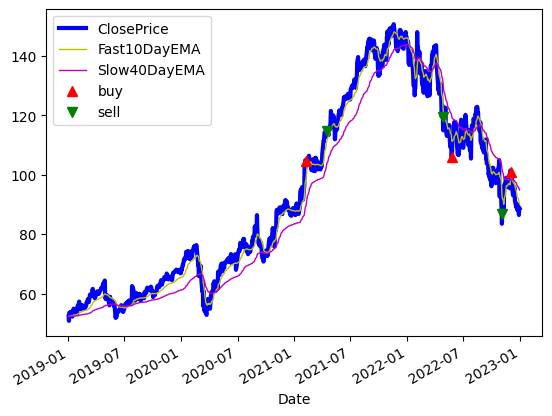

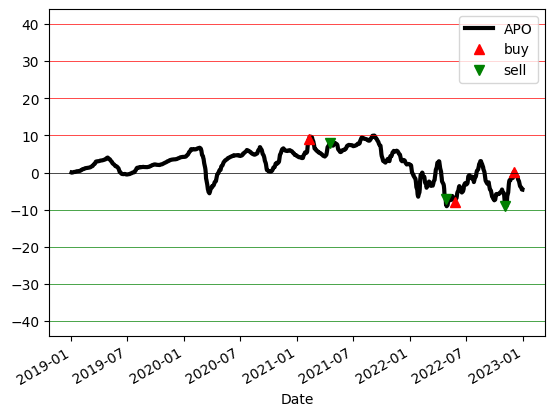

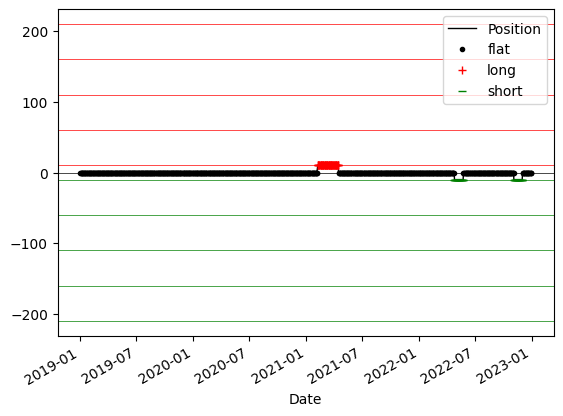

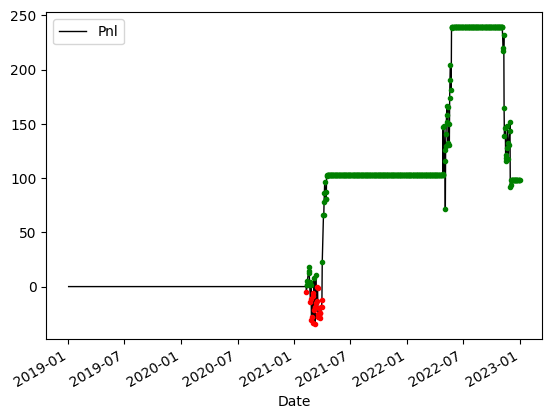

In [13]:
# 시각화 과정은 APO, Position, Pnl 순으로 위와 같은 결과를 따른다.
# 정적 상수 임계값 평균회귀 전략 vs 변동성-조정 평균 회귀 전략의 Pnl을 비교해 성과가 향상되었는지 확인하자.
import matplotlib.pyplot as plt

data['ClosePrice'].plot(color='blue', lw=3., legend=True)
data['Fast10DayEMA'].plot(color='y', lw=1., legend=True)
data['Slow40DayEMA'].plot(color='m', lw=1., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.ClosePrice[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.ClosePrice[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

data['APO'].plot(color='k', lw=3., legend=True)
plt.plot(data.loc[ data.Trades == 1 ].index, data.APO[data.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(data.loc[ data.Trades == -1 ].index, data.APO[data.Trades == -1 ], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Position'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Position == 0 ].index, data.Position[ data.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(data.loc[ data.Position > 0 ].index, data.Position[ data.Position > 0 ], color='r', lw=0, marker='+', label='long')
plt.plot(data.loc[ data.Position < 0 ].index, data.Position[ data.Position < 0 ], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range( NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range( -NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5 ):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

data['Pnl'].plot(color='k', lw=1., legend=True)
plt.plot(data.loc[ data.Pnl > 0 ].index, data.Pnl[ data.Pnl > 0 ], color='g', lw=0, marker='.')
plt.plot(data.loc[ data.Pnl < 0 ].index, data.Pnl[ data.Pnl < 0 ], color='r', lw=0, marker='.')
plt.legend()
plt.show()

# data.to_csv("volatility_adjusted_trend_following.csv", sep=",")

### 통계적 차익 거래의 이해와 구현

- 통계적 차익거래 (StatArb, Statistical Arbitrage)

- StatArb 리드-래그: 시장 참여자들의 반응 관점에서 내재적으로 포트폴리오가 선도하고 트레이딩 상품은 뒤쳐져있다고 예상. (수익성을 유지하고자 뒤쳐져있는 거래 상품을 찾고, 선도하는 상품 포트폴리오를 구축)

- 포트폴리오 구성과 관계 조정: StatArb 전략을 구축하는 중요 요소로서 변화하는 포트폴리오 구성 및 다양한 상품 간의 관계에 적응하도록 시스템 구축.

- 그 외 인프라 비용도 문제.

In [11]:

'''
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from itertools import cycle

# 데이터 불러오기
TRADING_INSTRUMENT = 'CADUSD=X'
# 미국달러(USD), 호주달러(AUD), 영국 파운드(GBP), 캐나다 달러(CAD), 스위스 프랑(CHF), 유로(EUR), 일본 엔(JPY), 뉴질랜드(NZD)
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']


start_date = '2021-01-01'
end_date = '2023-10-30'

# 빈 데이터프레임 생성
symbols_data = pd.DataFrame()

# 주식 종목 데이터 불러오기 및 Adj Close 열 데이터 가져오기
for symbol in SYMBOLS:
    stock_data = fdr.DataReader(symbol, start_date, end_date)
    stock_data.set_index('Symbol', inplace=True)
    symbols_data[symbol] = stock_data['Close']  # 해당 종목의 이름으로 열 추가

cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:
    multiplier = 1.0
    if symbol == 'JPYUSD=X':
        multiplier = 100.0

    label = symbol + ' ClosePrice'
    price_data[label] = symbols_data[symbol] * multiplier

for label in price_data.columns:
    ax = price_data[label].plot(color=next(cycol), lw=2., label=label)

plt.xlabel('Date', fontsize=10)
plt.ylabel('Scaled Price', fontsize=10)
plt.legend(prop={'size': 10})
plt.show()
'''

"\nimport pandas as pd\nimport FinanceDataReader as fdr\nimport matplotlib.pyplot as plt\nfrom itertools import cycle\n\n# 데이터 불러오기\nTRADING_INSTRUMENT = 'CADUSD=X'\n# 미국달러(USD), 호주달러(AUD), 영국 파운드(GBP), 캐나다 달러(CAD), 스위스 프랑(CHF), 유로(EUR), 일본 엔(JPY), 뉴질랜드(NZD)\nSYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']\n\n\nstart_date = '2021-01-01'\nend_date = '2023-10-30'\n\n# 빈 데이터프레임 생성\nsymbols_data = pd.DataFrame()\n\n# 주식 종목 데이터 불러오기 및 Adj Close 열 데이터 가져오기\nfor symbol in SYMBOLS:\n    stock_data = fdr.DataReader(symbol, start_date, end_date)\n    stock_data.set_index('Symbol', inplace=True)\n    symbols_data[symbol] = stock_data['Close']  # 해당 종목의 이름으로 열 추가\n\ncycol = cycle('bgrcmky')\n\nprice_data = pd.DataFrame()\nfor symbol in SYMBOLS:\n    multiplier = 1.0\n    if symbol == 'JPYUSD=X':\n        multiplier = 100.0\n\n    label = symbol + ' ClosePrice'\n    price_data[label] = symbols_data[symbol] * multiplier\n\nfor label in price_data.column

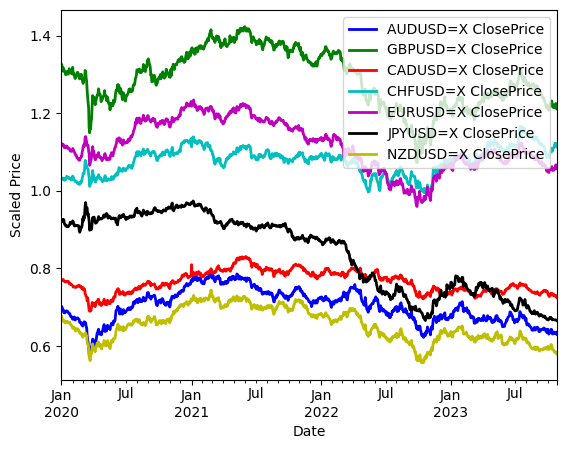

In [14]:
import pandas as pd
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from itertools import cycle

# 데이터 불러오기
TRADING_INSTRUMENT = 'CADUSD=X'
# 미국달러(USD), 호주달러(AUD), 영국 파운드(GBP), 캐나다 달러(CAD), 스위스 프랑(CHF), 유로(EUR), 일본 엔(JPY), 뉴질랜드(NZD)
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']

start_date = '2020-01-01'
end_date = '2023-10-29'

# 빈 데이터프레임 생성
symbols_data = pd.DataFrame()

# 주식 종목 데이터 불러오기 및 Adj Close 열 데이터 가져오기
for symbol in SYMBOLS:
    stock_data = fdr.DataReader(symbol, start_date, end_date)
    symbols_data[symbol] = stock_data['Close']  # 해당 종목의 이름으로 열 추가
    # 날짜 형식을 변경하고 날짜 열로 설정


cycol = cycle('bgrcmky')

price_data = pd.DataFrame()
for symbol in SYMBOLS:
    multiplier = 1.0
    if symbol == 'JPYUSD=X':
        multiplier = 100.0

    label = symbol + ' ClosePrice'
    price_data[label] = symbols_data[symbol] * multiplier

# 날짜를 x 축으로 사용하여 그래프 그리기
for label in price_data.columns:
    ax = price_data.index = pd.to_datetime(symbols_data.index)  # 날짜 인덱스 설정
    price_data[label].plot(color=next(cycol), lw=2., label=label)

plt.xlabel('Date', fontsize=10)
plt.ylabel('Scaled Price', fontsize=10)
plt.legend(prop={'size': 10})
plt.show()

In [15]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,0.678580,0.678580,0.672300,0.678580,0.678580,0
2020-01-02,0.673709,0.674032,0.668659,0.673718,0.673718,0
2020-01-03,0.669940,0.670040,0.664620,0.670021,0.670021,0
2020-01-06,0.665850,0.668100,0.664558,0.665531,0.665531,0
2020-01-07,0.666920,0.668000,0.662651,0.666951,0.666951,0
...,...,...,...,...,...,...
2023-10-23,0.582931,0.584518,0.580840,0.582931,0.582931,0
2023-10-24,0.585110,0.587270,0.582999,0.585110,0.585110,0
2023-10-25,0.584700,0.587072,0.581091,0.584700,0.584700,0


In [16]:
symbols_data

,AUDUSD=X,GBPUSD=X,CADUSD=X,CHFUSD=X,EURUSD=X,JPYUSD=X,NZDUSD=X
Date,,,,,,,
2020-01-01,0.701700,1.326260,0.769112,1.033912,1.122083,0.009201,0.678580
2020-01-02,0.701951,1.325030,0.770832,1.033592,1.122083,0.009199,0.673718
2020-01-03,0.698519,1.315270,0.770238,1.029654,1.117144,0.009213,0.670021
2020-01-06,0.694420,1.308010,0.770024,1.029357,1.116196,0.009262,0.665531
2020-01-07,0.693731,1.317003,0.771373,1.032524,1.119799,0.009225,0.666951
...,...,...,...,...,...,...,...
2023-10-23,0.632039,1.216397,0.729767,1.119570,1.058997,0.006672,0.582931
2023-10-24,0.633670,1.225025,0.730540,1.122838,1.066985,0.006677,0.585110
2023-10-25,0.636100,1.216190,0.727717,1.119746,1.059535,0.006673,0.584700


In [17]:
# 날짜 형식을 변경하고 날짜 열로 설정
price_data

,AUDUSD=X ClosePrice,GBPUSD=X ClosePrice,CADUSD=X ClosePrice,CHFUSD=X ClosePrice,EURUSD=X ClosePrice,JPYUSD=X ClosePrice,NZDUSD=X ClosePrice
Date,,,,,,,
2020-01-01,0.701700,1.326260,0.769112,1.033912,1.122083,0.9201,0.678580
2020-01-02,0.701951,1.325030,0.770832,1.033592,1.122083,0.9199,0.673718
2020-01-03,0.698519,1.315270,0.770238,1.029654,1.117144,0.9213,0.670021
2020-01-06,0.694420,1.308010,0.770024,1.029357,1.116196,0.9262,0.665531
2020-01-07,0.693731,1.317003,0.771373,1.032524,1.119799,0.9225,0.666951
...,...,...,...,...,...,...,...
2023-10-23,0.632039,1.216397,0.729767,1.119570,1.058997,0.6672,0.582931
2023-10-24,0.633670,1.225025,0.730540,1.122838,1.066985,0.6677,0.585110
2023-10-25,0.636100,1.216190,0.727717,1.119746,1.059535,0.6673,0.584700


### StatArb 시그널 파라미터 정의

In [18]:
import statistics as stats

# 단순 이동평균과 단순 이동평균으로부터의 가격 편차를 계산하는데 사용하는 상수/변수
SMA_NUM_PERIODS = 20  # 룩백 기간
price_history = {}  # 가격 히스토리

PRICE_DEV_NUM_PRICES = 200 # SMA로부터의 종가 편차를 수집하는 룩백 기간
price_deviation_from_sma = {}  # SMA로부터의 종가 편차의 히스토리

# 다음을 사용해 수집한 모든 일자의 데이터에 대해 반복 시행.
num_days = len(symbols_data[TRADING_INSTRUMENT].index)
correlation_history = {} # 통화 쌍 간의 상관관계 히스토리
delta_projected_actual_history = {} # 예측된 종가 편차와 실제 종가 편차와의 차이의 히스토리

final_delta_projected_history = [] # 거래상품 (Trading_Instrument)에 대한 최종 예측 종가 편차와 실제 종가 편차와의 차이의 히스토리  

### StatArb 트레이딩 파라미터 정의

In [19]:
# 전략 트레이드, 포지션과 손익(Pnl) 관리를 위한 변수

orders = []  # 매수 +1 / 매도 -1 / 주문 없으면 0
positions = []  # 롱 포지션 + / 숏 포지션 - / 포지션이 청산되거나 없으면 0
pnls = []  # 결제 포지션과 미체결 포지션의 합.

last_buy_price = 0  
last_sell_price = 0  
position = 0  
buy_sum_price_qty = 0  
buy_sum_qty = 0  
sell_sum_price_qty = 0  
sell_sum_qty = 0  
open_pnl = 0  
closed_pnl = 0

# 전략 행태 / 임계값을 정의하는 상수
StatArb_VALUE_FOR_BUY_ENTRY = 0.01 # 그 위로 매수 주문/롱 포지션을 진입하는 StatArb 트레이딩 시그널 값.
StatArb_VALUE_FOR_SELL_ENTRY = -0.01 
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01 # 트레이딩을 재개하기 위한 마지막 거래로부터의 최소 가격 변화. 과다 트레이딩 방지.  
NUM_SHARES_PER_TRADE = 1000000 # 모든 거래에 대해 매수/매도하는 통화 수
MIN_PROFIT_TO_CLOSE = 10 # 포지션을 청산하고 이익을 고정하기 위한 최소 미결제/미실현 이익   


### StatArb트레이딩 시그널 계량화와 계산

In [ ]:
for i in range(0, num_days):
  close_prices = {}

  # 종가 시리즈 구축. 각 종목(심벌)에 대한 SMA와 각 종목의 SMA로부터의 가격 편차를 계산.
  for symbol in SYMBOLS:
    #close_prices[symbol] = symbols_data[symbol]['Close'].iloc[i] #Close가 없어서 빼고 아래와 같이. 수정해봄.
    close_prices[symbol] = symbols_data[symbol].iloc[i]
    if not symbol in price_history.keys():
      price_history[symbol] = []
      price_deviation_from_sma[symbol] = []

    price_history[symbol].append(close_prices[symbol])
    if len(price_history[symbol]) > SMA_NUM_PERIODS:  # 적어도 SMA_NUM_PERIODS 수만큼의 가격을 추적.
      del (price_history[symbol][0])

    sma = stats.mean(price_history[symbol]) # 롤링 단순 이동 평균
    price_deviation_from_sma[symbol].append(close_prices[symbol] - sma) # 평균으로부터 가격 편차.
    if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
      del (price_deviation_from_sma[symbol][0])

  # 거래 수단과 모든 다른 선도 심벌과의 공분산과 상관계수 계산.
  # 예측된 가격 편차를 계산. 예측과 실제 가격 편차 간의 델타 발견.
  projected_dev_from_sma_using = {}
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # 거래 수단과 그 자체의 관계 찾을 필요 없음.
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    if correlation_label not in correlation_history.keys(): # 히스토리 딕셔너리 내의 이 쌍에 대한 첫 번째 원소
      correlation_history[correlation_label] = []
      delta_projected_actual_history[correlation_label] = []

    if len(price_deviation_from_sma[symbol]) < 2: # 공분산/상관계수를 계산하는데 적어도 2개의 관찰값 필요.
      correlation_history[correlation_label].append(0)
      delta_projected_actual_history[correlation_label].append(0)
      continue

    corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    corr_trading_instrument_lead_instrument = corr[0, 1]  # 2 시리즈 간의 상관계수.
    cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1] # 2 시리즈 간의 공분산

    correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)

    # 예측된 거래 수단의 가격 편차는 공분산 * 선도 심벌의 가격 편차.
    projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1] * cov_trading_instrument_lead_instrument

    # 델타가 양이면 시그널은 거래 수단 가격이 오른 것보다 더 오르는 것을 제시.
    # 델타가 음이면 시그널은 거래 수단 가격이 내린 것보다 더 하락할 것을 제시.
    delta_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])
    delta_projected_actual_history[correlation_label].append(delta_projected_actual)

  # 각 쌍으로부터의 가중치 예측, 가중치는 이들 쌍의 상관계수.
  sum_weights = 0 # 가중치의 합은 각 심벌의 거래 수단과의 상관관계의 합.
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # 거래 수단과 자신과의 관계는 필요없음.
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol
    sum_weights += abs(correlation_history[correlation_label][-1])

  final_delta_projected = 0 # 다른 모든 심벌로부터의 예측을 가중 평균한 거래 수단의 마지막 가격 편차 예측을 보유.
  close_price = close_prices[TRADING_INSTRUMENT]
  for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT:  # 거래 수단과 자신과의 관계는 필요 없음.
      continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol

    # 상관계수로 심벌의 가중치 예측.
    final_delta_projected += (abs(correlation_history[correlation_label][-1]) * delta_projected_actual_history[correlation_label][-1])

  # 모든 쌍에 대한 가중 합으로 나눠 정규화
  if sum_weights != 0:
    final_delta_projected /= sum_weights
  else:
    final_delta_projected = 0

  final_delta_projected_history.append(final_delta_projected)

  # trading signal 
  
  # sell trade 
  if ((final_delta_projected < StatArb_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  
      or
      (position > 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))): 
    orders.append(-1)  
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE  
    sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))

  # buy trade 
  elif ((final_delta_projected > StatArb_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  
        or
        (position < 0 and (open_pnl > MIN_PROFIT_TO_CLOSE))): 
    orders.append(+1)  
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE  
    buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))
  else:
    
    orders.append(0)

  positions.append(position)

  # 미결제/미실현과 결제/실현 포지션 업데이트 
  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: 
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0: 
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
  else:
    
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  pnls.append(closed_pnl + open_pnl)

### StatArb 시그널 및 전략 성능 분석

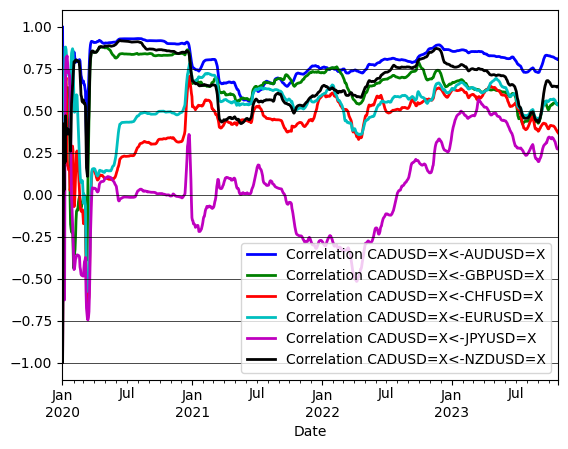

In [21]:
# 거래 수단과 다른 통화 쌍과의 상관계수
# 1에 가까울수록 상관관계가 높은 통화임을 알 수 있다.

correlation_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  correlation_label = TRADING_INSTRUMENT + '<-' + symbol
  correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=symbols_data[symbol].index))
  ax = correlation_data['label'].plot(color=next(cycol), lw=2., label='Correlation ' + correlation_label)

for i in np.arange(-1, 1, 0.25):
  plt.axhline(y=i, lw=0.5, color='k')
plt.legend()
plt.show()

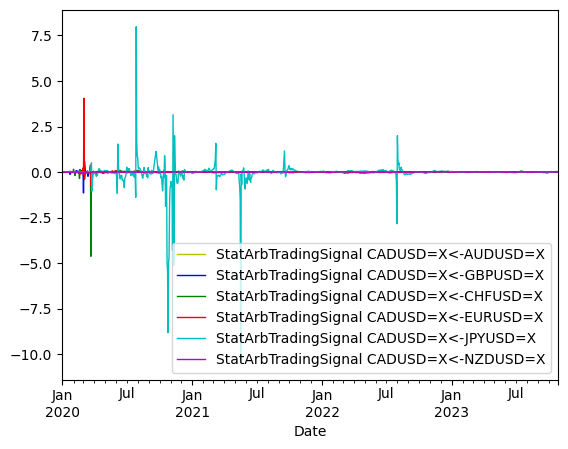

In [22]:
# 각 통화 쌍에 의해 제공되는 StatArb 시그널
# 어떤 통화가 거래 신호가 빈번하게 바뀌는지

delta_projected_actual_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  projection_label = TRADING_INSTRUMENT + '<-' + symbol
  delta_projected_actual_data = delta_projected_actual_data.assign(StatArbTradingSignal=pd.Series(delta_projected_actual_history[projection_label], index=symbols_data[TRADING_INSTRUMENT].index))
  ax = delta_projected_actual_data['StatArbTradingSignal'].plot(color=next(cycol), lw=1., label='StatArbTradingSignal ' + projection_label)
plt.legend()
plt.show()

- JPYUSD가 매우 큰 예측값을 가지고 있음을 시사한다.
- 하지만 첫 번째 그래프에서 JPYUSD-CADUSD 사이의 상관관계가 좋지 않았기 때문에 예측관계가 좋지 않다.
- 특정 쌍 사이의 관계가 붕괴될 때, 다른 강한 상관관계 쌍이 나쁜 예측을 상쇄하는데 도움이 될 수 있다.
- 따라서 StatArb는 여러 주요 거래 상품을 보유함으로써 이익을 얻어야 한다.

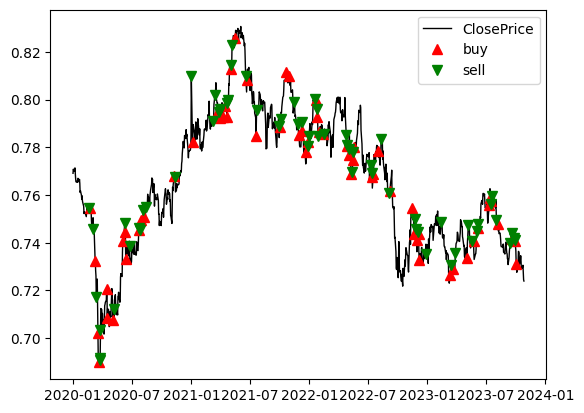

In [23]:
#매수와 매도를 수행할 때의 가격.

# delta_projected_actual_data = delta_projected_actual_data.assign(ClosePrice=pd.Series(symbols_data[TRADING_INSTRUMENT]['Close'], index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(ClosePrice=pd.Series(symbols_data[TRADING_INSTRUMENT], index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(FinalStatArbTradingSignal=pd.Series(final_delta_projected_history, index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(Trades=pd.Series(orders, index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(Position=pd.Series(positions, index=symbols_data[TRADING_INSTRUMENT].index))
delta_projected_actual_data = delta_projected_actual_data.assign(Pnl=pd.Series(pnls, index=symbols_data[TRADING_INSTRUMENT].index))

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.ClosePrice, color='k', lw=1., label='ClosePrice')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.ClosePrice[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.ClosePrice[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.show()

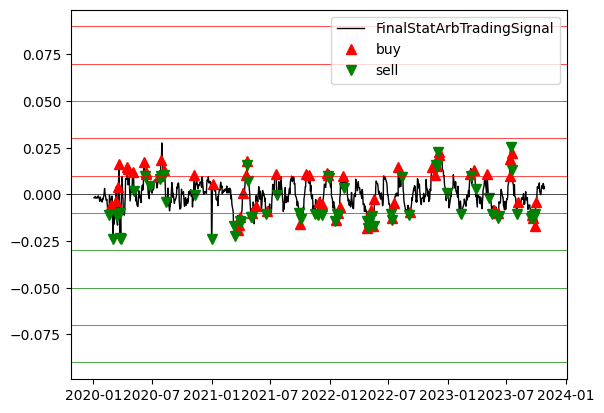

In [24]:
# 양수이면 매수, 음수이면 매도. 매수/매도 시그널을 나타냄.

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.FinalStatArbTradingSignal, color='k', lw=1., label='FinalStatArbTradingSignal')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in np.arange(StatArb_VALUE_FOR_BUY_ENTRY, StatArb_VALUE_FOR_BUY_ENTRY * 10, StatArb_VALUE_FOR_BUY_ENTRY * 2):
  plt.axhline(y=i, lw=0.5, color='r')
for i in np.arange(StatArb_VALUE_FOR_SELL_ENTRY, StatArb_VALUE_FOR_SELL_ENTRY * 10, StatArb_VALUE_FOR_SELL_ENTRY * 2):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

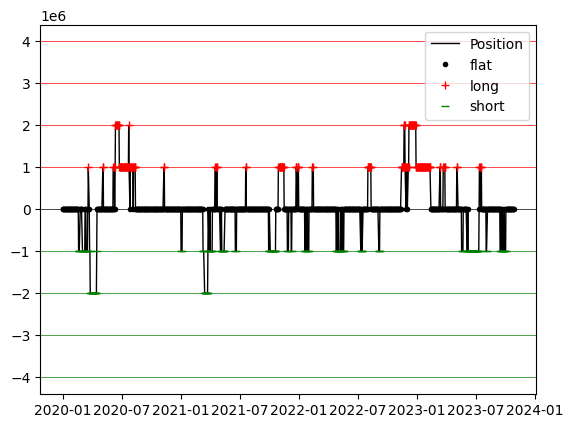

In [25]:
# 포지션

plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.Position, color='k', lw=1., label='Position')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position == 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position == 0], color='k', lw=0, marker='.', label='flat')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position > 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position > 0], color='r', lw=0, marker='+', label='long')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Position < 0].index, delta_projected_actual_data.Position[delta_projected_actual_data.Position < 0], color='g', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')
for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE * 5, NUM_SHARES_PER_TRADE):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE * 5, -NUM_SHARES_PER_TRADE):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

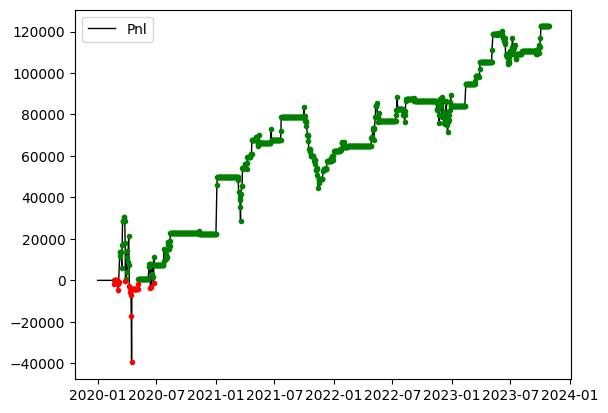

In [26]:
plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.Pnl, color='k', lw=1., label='Pnl')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Pnl > 0].index, delta_projected_actual_data.Pnl[delta_projected_actual_data.Pnl > 0], color='g', lw=0, marker='.')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Pnl < 0].index, delta_projected_actual_data.Pnl[delta_projected_actual_data.Pnl < 0], color='r', lw=0, marker='.')
plt.legend()
plt.show()

# delta_projected_actual_data.to_csv("statistical_arbitrage.csv", sep=",")

### 경제 이벤트 트레이딩 전략

- https://tradingeconomics.com/
- https://www.forexfactory.com/
- https://www.fxstreet.com/